In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./energy_dataset (1).csv')

In [3]:
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.strftime('%d.%m.%Y')
df.time=df.time.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y')) # UDF로 time index 만들기
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35063 entries, 0 to 35062
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   time                                         35063 non-null  datetime64[ns]
 1   generation biomass                           35044 non-null  float64       
 2   generation fossil brown coal/lignite         35045 non-null  float64       
 3   generation fossil coal-derived gas           35045 non-null  float64       
 4   generation fossil gas                        35045 non-null  float64       
 5   generation fossil hard coal                  35045 non-null  float64       
 6   generation fossil oil                        35044 non-null  float64       
 7   generation fossil oil shale                  35045 non-null  float64       
 8   generation fossil peat                       35045 non-null  float64       


In [4]:
df['date_block_num'] = (df['time'].dt.year - 2015) * 12 + df['time'].dt.month-1

In [5]:
# Make time series
ts=df.groupby(["time"])["generation biomass"].sum()
ts.astype('float')
ts

time
2015-01-01    10205.0
2015-01-02     9357.0
2015-01-03    10485.0
2015-01-04     9513.0
2015-01-05     6295.0
               ...   
2018-12-27     7312.0
2018-12-28     7591.0
2018-12-29     6924.0
2018-12-30     6608.0
2018-12-31     6817.0
Name: generation biomass, Length: 1461, dtype: float64

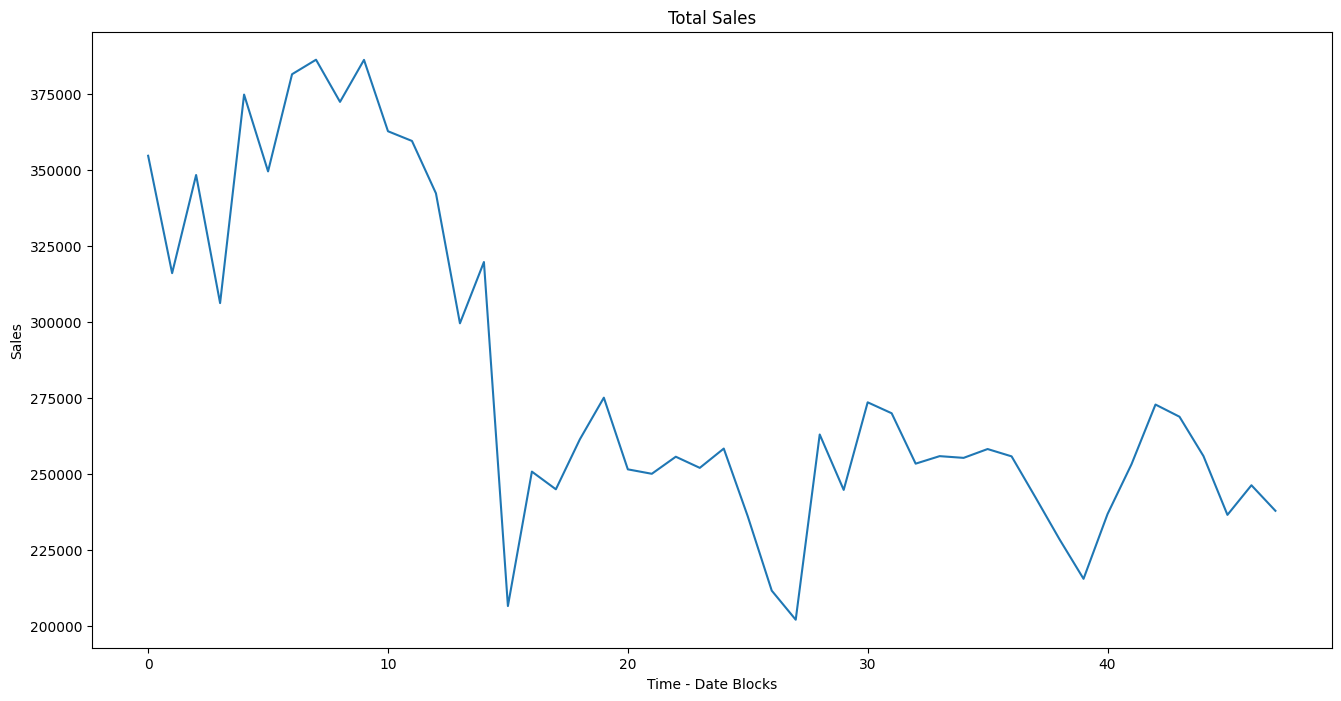

In [7]:
ts = df.groupby(["date_block_num"])["generation biomass"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.xlabel('Time - Date Blocks')
plt.ylabel('Sales')
plt.title('Total Sales')
plt.show()

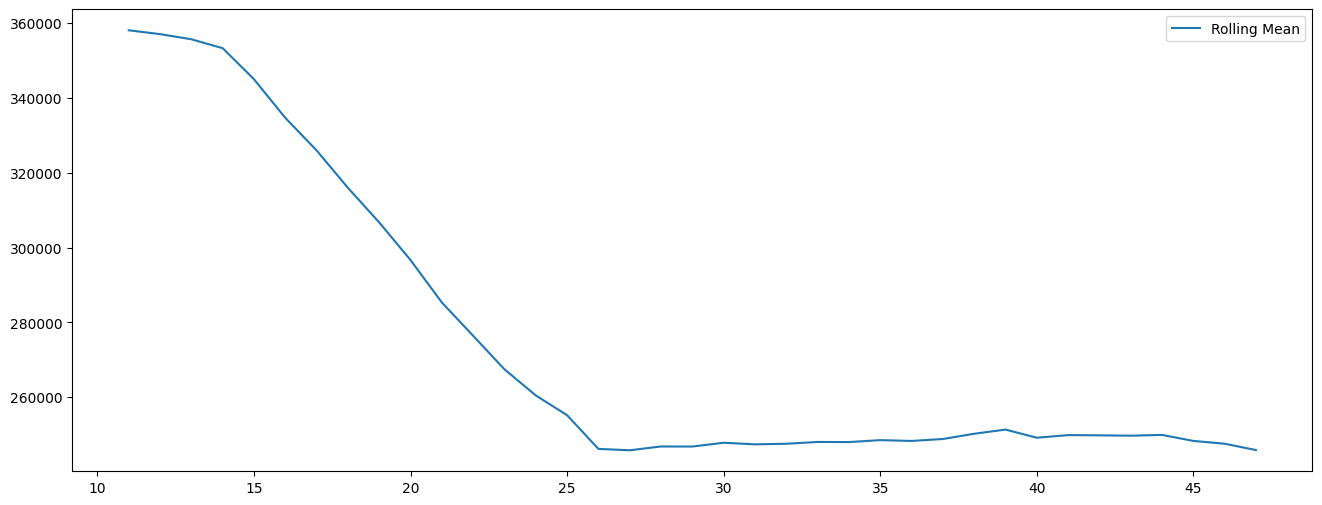

In [8]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.legend()
plt.show()

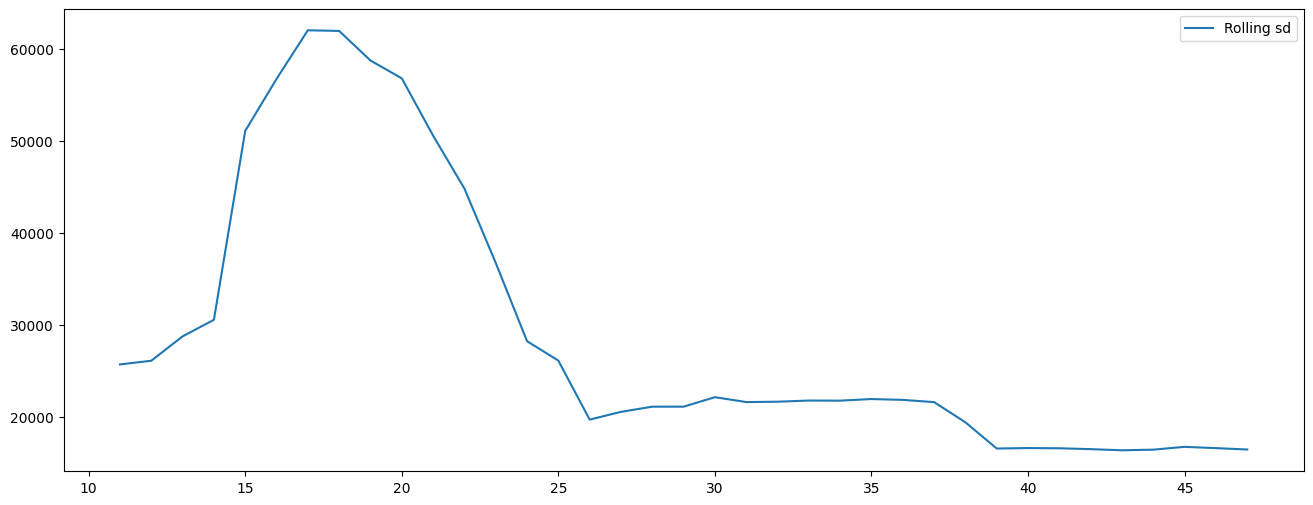

In [9]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()
plt.show()

<Figure size 1600x1200 with 0 Axes>

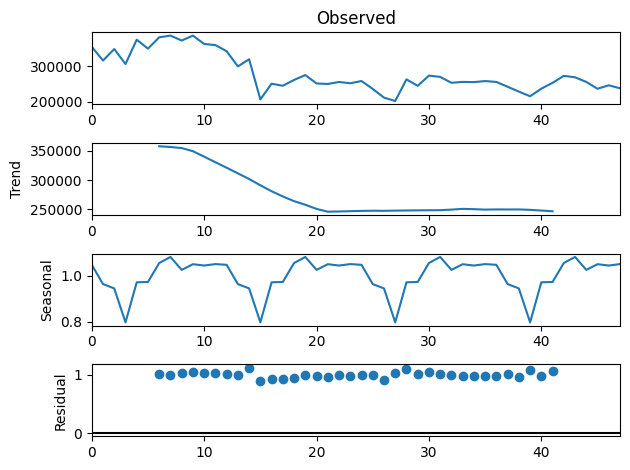

In [10]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# multiplicative decomposition
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")

# 그래프 크기 설정
plt.figure(figsize=(16, 12))

# 결과를 그래프로 출력
fig = res.plot()

# 그래프 표시
plt.show()

In [11]:
# Testing for Stationarity
def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.229520
p-value                         0.660770
# Lags Used                     1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [17]:
# Add dates to Time-series as index
ts=df.groupby(["date_block_num"])["generation biomass"].sum()
ts.index=pd.date_range(start = '2015-01-01',end='2018-12-31', freq = 'MS') # Month Start
ts=ts.reset_index()
ts.head()

,index,generation biomass
0,2015-01-01,354564.0
1,2015-02-01,315992.0
2,2015-03-01,348245.0
3,2015-04-01,306162.0
4,2015-05-01,374663.0


In [18]:
ts.columns=['ds','y']

In [19]:
# model = Prophet(model_params)
model = Prophet(yearly_seasonality=True)  # Intantiate the model

In [20]:
model = Prophet(yearly_seasonality=True) # Prophet object can only be fit once. Instantiate a new object when running multiple times
model.fit(ts) # fit the model

18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing


### 분석결과

In [21]:
# Predict for five months in the furure
future = model.make_future_dataframe(periods = 12, freq = 'MS')  # MS - month start
forecast = model.predict(future)

In [22]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,377382.985070,358452.114049,408929.600089,377382.985070,377382.985070,6386.046837,6386.046837,6386.046837,6386.046837,6386.046837,6386.046837,0.0,0.0,0.0,383769.031907
1,2015-02-01,371810.771280,326161.251662,375835.208684,371810.771280,371810.771280,-21940.311287,-21940.311287,-21940.311287,-21940.311287,-21940.311287,-21940.311287,0.0,0.0,0.0,349870.459993
2,2015-03-01,366777.803982,310111.469133,362965.323855,366777.803982,366777.803982,-28736.115940,-28736.115940,-28736.115940,-28736.115940,-28736.115940,-28736.115940,0.0,0.0,0.0,338041.688042
3,2015-04-01,361205.590189,291904.157296,341432.919837,361205.590189,361205.590189,-43264.650193,-43264.650193,-43264.650193,-43264.650193,-43264.650193,-43264.650193,0.0,0.0,0.0,317940.939995
4,2015-05-01,355813.125225,335630.813145,389102.087585,355813.125225,355813.125225,6148.495449,6148.495449,6148.495449,6148.495449,6148.495449,6148.495449,0.0,0.0,0.0,361961.620675


In [23]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2019-08-01,244937.288751,219815.829384,270371.157975
56,2019-09-01,235016.855906,212188.703406,260102.714147
57,2019-10-01,243569.392811,218121.114228,268567.533431
58,2019-11-01,239154.572588,215925.044378,264682.904248
59,2019-12-01,245188.072848,220751.240899,269643.349421


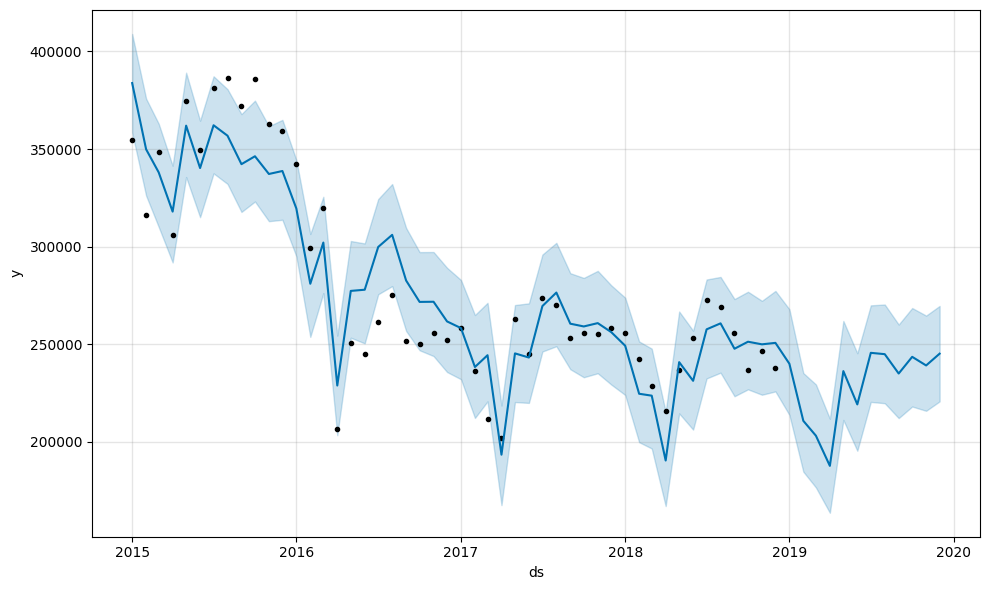

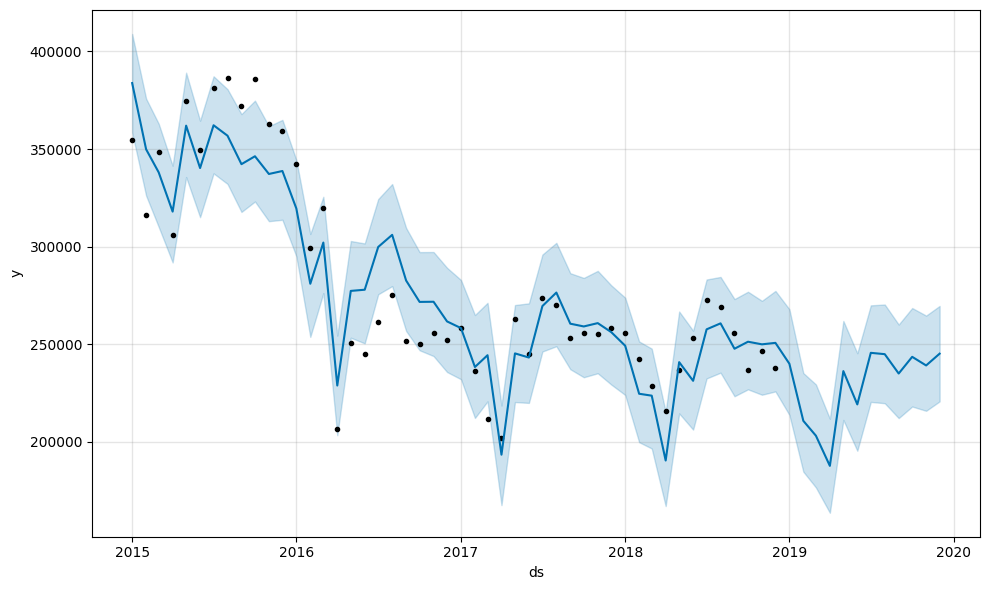

In [24]:
model.plot(forecast)

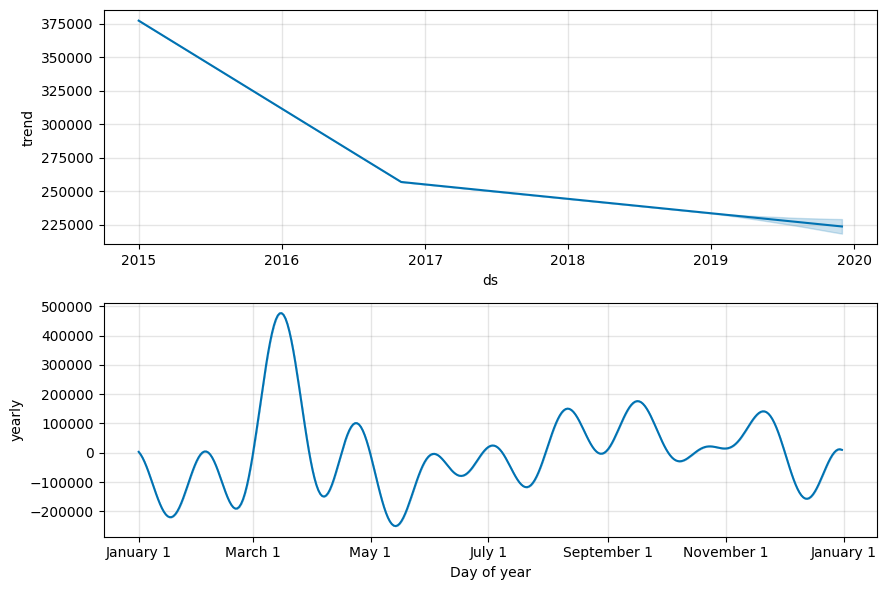

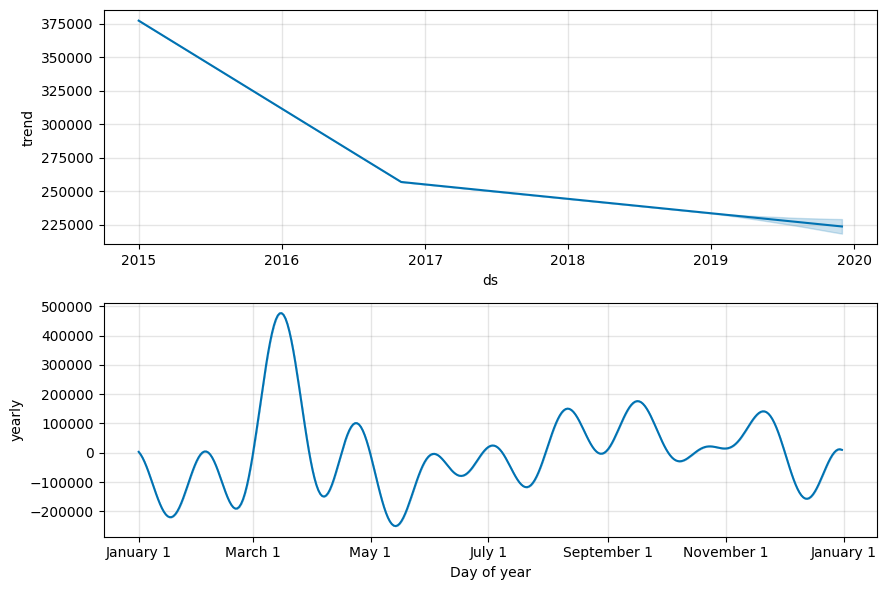

In [25]:
# plot the model forecast chart with component charts in trend and seasonality
model.plot_components(forecast)

In [26]:
# Show all forecasting values in a table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,383769.031907,358452.114049,408929.600089
1,2015-02-01,349870.459993,326161.251662,375835.208684
2,2015-03-01,338041.688042,310111.469133,362965.323855
3,2015-04-01,317940.939995,291904.157296,341432.919837
4,2015-05-01,361961.620675,335630.813145,389102.087585
5,2015-06-01,340251.167357,315090.032187,364511.083476
6,2015-07-01,362154.711542,337530.981610,387237.724437
7,2015-08-01,356817.290046,332120.793601,380629.936429
8,2015-09-01,342238.889519,317769.556115,367867.665261
9,2015-10-01,346283.715763,323114.715715,374771.614544
